In [1]:
pip install pandas


[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install numpy



[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

In [33]:
EPOCHS = 50
IMAGE_SIZE = (128, 128)
INPUT_SHAPE = (128, 128, 3)
DATASET_DIR = "C:/Users/knrah/Downloads/sugarcane"
SEED = 123
BATCH_SIZE = 32
BUFFER_SIZE = 250
FINE_TUNE_POINT = 125
LEARNING_RATE = 0.001

In [34]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    labels="inferred",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset="training"
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    labels="inferred",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    seed=SEED,
    validation_split=0.2,
    subset="validation"
)

Found 2521 files belonging to 5 classes.
Using 2017 files for training.
Found 2521 files belonging to 5 classes.
Using 504 files for validation.


In [35]:
class_names = train_ds.class_names

In [36]:
for example_image, example_label in train_ds.take(1):
  break

print(f"Image Shape: {example_image.shape}")

Image Shape: (32, 128, 128, 3)


In [37]:
validation_ds = validation_ds.shard(num_shards=2, index=0)
test_ds = validation_ds.shard(num_shards=2, index=1)

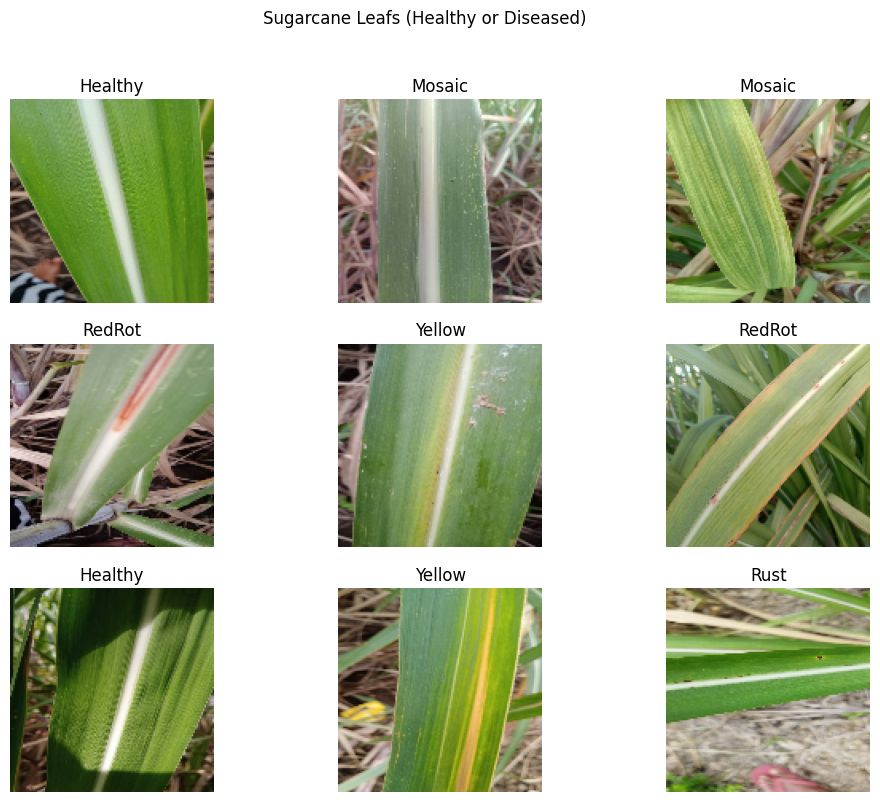

In [38]:
plt.figure(figsize=(12, 9))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.suptitle("Sugarcane Leafs (Healthy or Diseased)")
        plt.axis("off")

In [39]:
train_ds = train_ds.cache().shuffle(BUFFER_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [40]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=INPUT_SHAPE,
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True

print(len(base_model.layers))

154


In [41]:
for layer in base_model.layers[:FINE_TUNE_POINT]:
  layer.trainable = False

In [42]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(len(class_names))
])

In [43]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [44]:
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=EPOCHS,
)

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 77s 602ms/step - accuracy: 0.5603 - loss: 1.1867 - val_accuracy: 0.7031 - val_loss: 1.4745
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 28s 431ms/step - accuracy: 0.8773 - loss: 0.3659 - val_accuracy: 0.4570 - val_loss: 5.8678
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 27s 418ms/step - accuracy: 0.9445 - loss: 0.2089 - val_accuracy: 0.5781 - val_loss: 5.1762
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 27s 416ms/step - accuracy: 0.9446 - loss: 0.1646 - val_accuracy: 0.6758 - val_loss: 3.8019
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 412ms/step - accuracy: 0.9385 - loss: 0.1923 - val_accuracy: 0.3555 - val_loss: 12.9392
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 27s 419ms/step - accuracy: 0.9617 - loss: 0.1270 - val_accuracy: 0.6016 - val_loss: 6.9100
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 34s 530ms/step - accuracy: 0.9746 - loss: 0.0890 - val_accuracy: 0.5117 - val_loss: 10.2570
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 37s 572ms/step - accuracy: 0.9842 - loss: 0.0481 - val_ac

Text(0.5, 0, 'Epoch')

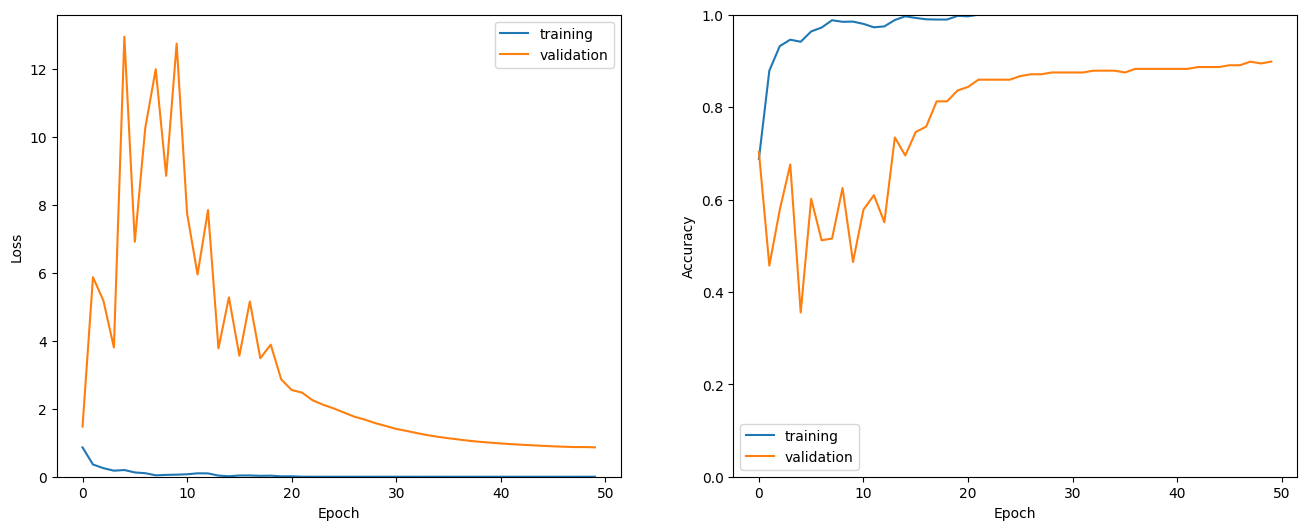

In [45]:
metrics = history.history
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['training', 'validation'])
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['training', 'validation'])
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

In [46]:
model.evaluate(test_ds, return_dict=True)
y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 574ms/step - accuracy: 0.9104 - loss: 1.0072
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 327ms/step


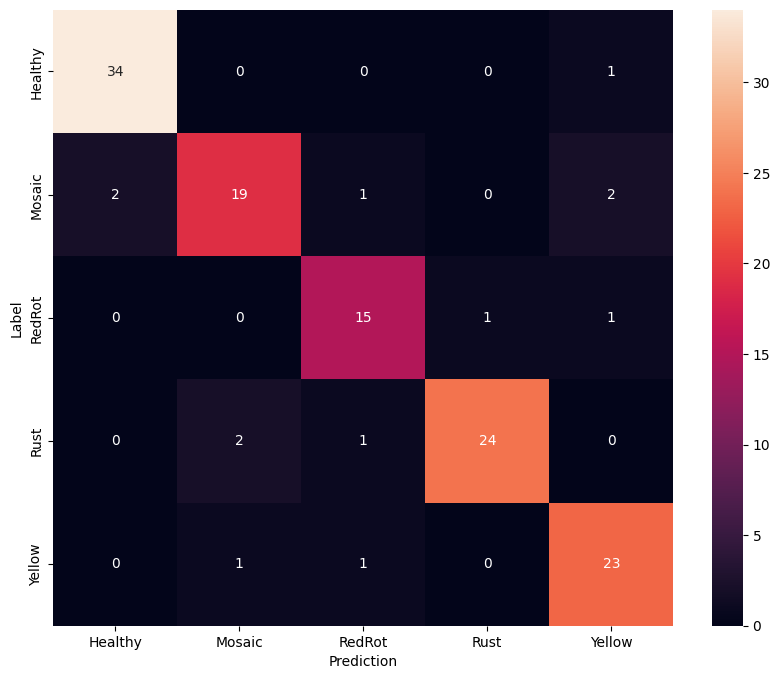

In [47]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=class_names,
            yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [48]:
from sklearn.metrics import accuracy_score, classification_report

# Predicting labels for the test dataset
y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

# Generate classification report
class_report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(class_report)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 342ms/step
Accuracy: 0.8984375
Classification Report:
              precision    recall  f1-score   support

     Healthy       0.94      0.97      0.96        35
      Mosaic       0.86      0.79      0.83        24
      RedRot       0.83      0.88      0.86        17
        Rust       0.96      0.89      0.92        27
      Yellow       0.85      0.92      0.88        25

    accuracy                           0.90       128
   macro avg       0.89      0.89      0.89       128
weighted avg       0.90      0.90      0.90       128

